In [2]:
!pip install contractions
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF

from wordcloud import WordCloud

import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import contractions

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# 1. Exploration du jeu de données

In [3]:
DATASET_FILE = "https://github.com/archiducarmel/TopicModelingDataset/releases/download/dataset/dataset.csv"

In [4]:
dataset_df = pd.read_csv(DATASET_FILE)
dataset_df

,text,stars
0,I've only had food from here once and it wasn'...,1
1,I will never return here again. Ever. I was ...,1
2,I wish my experience was great as others. I di...,1
3,Are the rosemary grapefruit scones supposed to...,1
4,Our takeout order was half wrong. Food was mis...,1
...,...,...
24995,I was a loyal fan of Aroy before the ownership...,5
24996,Stopped here for a bite while wandering around...,5
24997,"A quiet place with excellent food, great music...",5
24998,Super delicious food. Awesome vibe. I suffered...,5


## 1.1 Répartition des avis clients en fonction du nombre d'étoiles

In [5]:
stars_columns = dataset_df.stars
stars_columns

0        1
1        1
2        1
3        1
4        1
        ..
24995    5
24996    5
24997    5
24998    5
24999    5
Name: stars, Length: 25000, dtype: int64

In [10]:
stars_columns.value_counts()

1    5000
2    5000
3    5000
4    5000
5    5000
Name: stars, dtype: int64

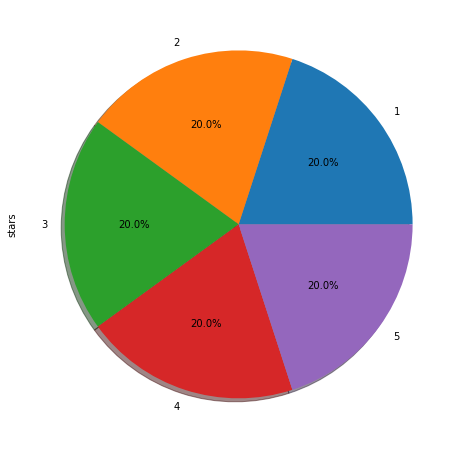

In [6]:
stars_columns.value_counts().plot(kind="pie", figsize=(10, 8), autopct="%1.1f%%", shadow=True)

## 1.2 Distribution de la longueur (nombre de mots) des avis clients

In [7]:
dataset_df["length"] = dataset_df["text"].apply(lambda x: len(x.split()))
dataset_df

,text,stars,length
0,I've only had food from here once and it wasn'...,1,68
1,I will never return here again. Ever. I was ...,1,87
2,I wish my experience was great as others. I di...,1,166
3,Are the rosemary grapefruit scones supposed to...,1,81
4,Our takeout order was half wrong. Food was mis...,1,32
...,...,...,...
24995,I was a loyal fan of Aroy before the ownership...,5,75
24996,Stopped here for a bite while wandering around...,5,55
24997,"A quiet place with excellent food, great music...",5,32
24998,Super delicious food. Awesome vibe. I suffered...,5,41


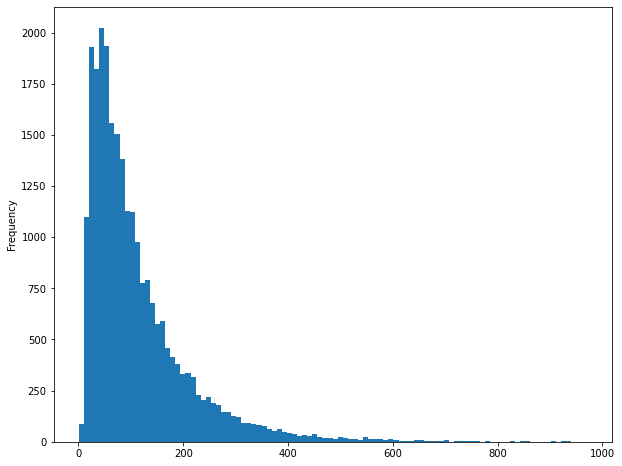

In [8]:
dataset_df.length.plot(kind="hist", bins=100, figsize=(10, 8))

## 1.3 Distribution de la longueur des avis clients en fonction du nombre d'étoiles des avis

Text(0.5, 1.0, "Répartition des longueurs des avis en fonction du nombre d'étoiles")

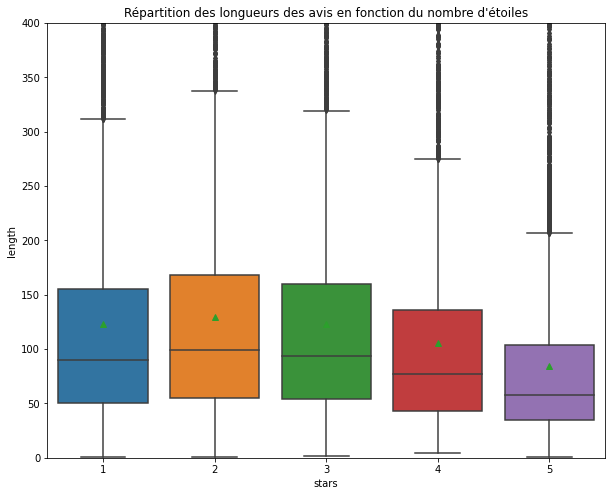

In [9]:
plt.figure(figsize=(10, 8))

ax = sns.boxplot(x=dataset_df.stars ,
            y=dataset_df.length,
            showmeans=True,
            )
ax.set_ylim(0, 400)

ax.set_title("Répartition des longueurs des avis en fonction du nombre d'étoiles")

# 2. Pré-traitement du jeu de données

In [10]:
#dataset pandas
dataset_pd = pd.DataFrame(dataset_df)
dataset_pd

,text,stars,length
0,I've only had food from here once and it wasn'...,1,68
1,I will never return here again. Ever. I was ...,1,87
2,I wish my experience was great as others. I di...,1,166
3,Are the rosemary grapefruit scones supposed to...,1,81
4,Our takeout order was half wrong. Food was mis...,1,32
...,...,...,...
24995,I was a loyal fan of Aroy before the ownership...,5,75
24996,Stopped here for a bite while wandering around...,5,55
24997,"A quiet place with excellent food, great music...",5,32
24998,Super delicious food. Awesome vibe. I suffered...,5,41


In [81]:
sentence="i can't jean "
sentence=contractions.fix(sentence)
print(sentence)

i cannot jean 


In [11]:
import nltk
from nltk.tokenize import TreebankWordTokenizer
nltk.download('omw-1.4')
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.tokenize import *

dataset_pd["length"] = dataset_pd["text"].apply(lambda x: len(x.split()))



#tokenization des données
def tokenizer(sentence):
  tokens_=TreebankWordTokenizer()

  tokenizer=tokens_.tokenize(sentence)
  return tokenizer
  
#contraction des données  
def contraction(sentence):
  sentence=contractions.fix(sentence)
  return sentence
  
#Lemmatization
def WordNetLemmatizer_NEG(tokenizer):
  lemmatizer = WordNetLemmatizer()
  tokenizer=lemmatizer.lemmatize(tokenizer)
  return tokenizer


#les stop_words negatif 
def tag_words(tokenizer):
  keywordSet = ["never", "nothing", "nowhere", "noone", "none", "not"]
  for i in range(len(tokenizer)):
    for k in range(len(keywordSet)):

      if tokenizer[i]==keywordSet[k] and not tokenizer[i]==tokenizer[-1]:
        tokenizer[i+1]="not_"+tokenizer[i+1]
        tokenizer[i]=="not"
  return tokenizer

#stop_word
def stop_words(tokenizer):
  stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', 've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn', "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"]
  for i in range(len(tokenizer)):
    for k in range(len(stop_words)):
      if tokenizer[i]==stop_words[k]:
        tokenizer[i]==""
  return tokenizer

#suppression des majuscules
def Lower_words(tokenizer):
  for i in range(len(tokenizer)):
    
    tokenizer[i]=tokenizer[i].lower()

  return tokenizer

#preprocessing
def preprocessing(data):
  
  for i in range(len(data["text"])):
    contraction_=contraction(data["text"][i])
    print(contraction_)
    #tokens=tokenizer(contraction_)
    #print(tokens)
    #lower=Lower_words(tokens)
    #print(lower)
    #tag=tag_words(lower)
    #print(tag)
    #stop=stop_words(tag)
    #word=WordNetLemmatizer_NEG(stop)
    #print(data["text"][i])
  return word

preprocessing(dataset_pd)

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
The last time I was here I had tried and liked the Parmesan fries, but this time they were so salty that I could not eat them. The fries were also so short that you could not grip them and dip them into the condiment. Clearly this was the bottom of the dregs.

Still might have given them three stars, but the two staff members I talked to did not seem to care when I mentioned that the fries were to salty to eat.

No valid reason to return.
This place is a complete wreck. I wait for 30 minutes to get my 4 for 4. Multiple people who ordered after me got there food first. The manager put my sandwich on the tray and it sat on the tray waiting for my other food for another 20 minutes. So my sandwich was cold. Then my fries were way way way over cooked. When I finally got my food the manager proceeded to SCREAM have a nice day at me because I did not acknowledge her the first time she said it I just nodded. On top o

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
What took it from 3 to 2 stars was waiting 20 minutes for the check (yes I timed it). Note to the server, you were not over tipped for service. Since you never returned after dropping of the bill - and I saw you drinking around the corner talking it up with coworkers - I paid what cash I had and left. 

Now I will never return
I do not really write reviews but I just could not let it go how uncomfortable they made me feel, with that being said for being a first time customer they really made me feel like I was inconveniencing them by not knowing their menu, and having a child with me. Food was ok service was terrible because I was not a regular, I had followed their wait list protocol but after a couple of they are regualars came in ( stafff and customers knew each other by first name basis) they we are seated before me. Staff just pretended not to acknowledge what I just saw and re assured me I would be seat

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
I had the lobster mac & cheese which was delish. There were large hunks of buttery lobster which made me tres happy. Husband had the steak frittes with mashed instead of sweet potato fries and he loved it. 

The reason it is getting 4 instead of 5 is because the heavenly rolls we were promised did not show up until we got our entrees and we had to ask for them. 

Overall it is a good spot with a city vibe (and free parking!) without having to venture over the Charles.
Thai Dish is my favorite Thai place in close proximity to my workplace. Definitely go there when the Sox are not in town or else it is packed with fans who order "Pad Thai" because "that is what you get at a Thai restaurant right?". The food is great and they are super welcoming to vegans and they make just about anything vegan friendly. They also fill your water glass promptly.
I am from a place where there are no good jamaican restaurants so w

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.

The entrees automatically come with side dishes. It was creamed spinach and mashed potatoes. The mashed potatoes were typical, nothing extraordinary...but very BUTTERY. The creamed spinach tasted like something you could get at a local Chili's restaurant or something of that sort...overly salty. Note: these side dishes are SHARED; you do not get your own plate of it or anything.

Finally, for dessert I got the creme brulee (a taste of heaven! ahhh!) and my boyfriend got the pear sorbet (tasted like real pears...except cold and melts easily). By this point I did not really care to look at the usual prices were but I image it is somewhat pricey just like the rest of the other items. 

TWO THUMBS UP for restaurant week and the FABULOUS view! Oh yes...another reviewer mentioned something about the long wait. I did not find that it was too long, but then again me and my bf came early to prevent this. Our reservat

,text,stars,length
0,I've only had food from here once and it wasn'...,1,68
1,I will never return here again. Ever. I was ...,1,87
2,I wish my experience was great as others. I di...,1,166
3,Are the rosemary grapefruit scones supposed to...,1,81
4,Our takeout order was half wrong. Food was mis...,1,32
...,...,...,...
24995,I was a loyal fan of Aroy before the ownership...,5,75
24996,Stopped here for a bite while wandering around...,5,55
24997,"A quiet place with excellent food, great music...",5,32
24998,Super delicious food. Awesome vibe. I suffered...,5,41
